In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.family': 'serif', 'mathtext.fontset': 'dejavuserif',
                 'font.size': 12, 'text.latex.preamble': r"\usepackage{amsmath}",
                 'xtick.major.pad': 2, 'ytick.major.pad': 2, 'xtick.major.size': 6, 'ytick.major.size': 6,
                 'xtick.minor.size': 3, 'ytick.minor.size': 3, 'axes.linewidth': 2, 'axes.labelpad': 1})

# from common.Tools
def format_axis(ax: mpl.axes._axes.Axes) -> None:
    ax.minorticks_on(); ax.grid(visible=True, which='major', linestyle=':')
    ax.tick_params(axis='both', which='both', direction='out')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.patch.set_alpha(0.0)

In [2]:
import pandas as pd
import numpy as np
from astropy import constants as const, units as u

In [3]:
COLUMNS = ['KIC', 'Mass', 'S_Mass', 'Radius', 'S_Radius', 'Logg_Seis', 'S_Logg_Seis', 'Teff', 'S_Teff',
           '[Fe/H]', 'S_[Fe/H]', '[Alp/Fe]', 'S_[Alp/Fe]', '[C/Fe]', 'S_[C/Fe]', '[N/Fe]', 'S_[N/Fe]']

df = pd.read_table('Table4.data', sep='\s+', low_memory=False)
df = df[(df['Evol_State'] == 'RGB') & (df['Cat_Tab'] == 'Gold') & (df['Alpha_Cat'] == 'Apoor')]
df = df[(df['Mass'] > -9999.0) & (df['Radius'] > -9999.0)]  # filter out bad values

df['Mass'] /= df['F_Numax']
df = df[COLUMNS]
df.set_index('KIC', inplace=True)
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3905 entries, 893214 to 12885196
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Mass         3905 non-null   float64
 1   S_Mass       3905 non-null   float64
 2   Radius       3905 non-null   float64
 3   S_Radius     3905 non-null   float64
 4   Logg_Seis    3905 non-null   float64
 5   S_Logg_Seis  3905 non-null   float64
 6   Teff         3905 non-null   float64
 7   S_Teff       3905 non-null   float64
 8   [Fe/H]       3905 non-null   float64
 9   S_[Fe/H]     3905 non-null   float64
 10  [Alp/Fe]     3905 non-null   float64
 11  S_[Alp/Fe]   3905 non-null   float64
 12  [C/Fe]       3905 non-null   float64
 13  S_[C/Fe]     3905 non-null   float64
 14  [N/Fe]       3905 non-null   float64
 15  S_[N/Fe]     3905 non-null   float64
dtypes: float64(16)
memory usage: 518.6 KB


In [4]:
for col in COLUMNS:
    if col == 'KIC': continue
    print(f'{col}: {df[col].min()}, {df[col].max()}')

Mass: 0.5214378953710211, 3.224805428058272
S_Mass: 0.0217, 0.1349
Radius: 4.0333, 52.9843
S_Radius: 0.0696, 0.9545
Logg_Seis: 1.278, 3.258
S_Logg_Seis: 0.0035, 0.0128
Teff: 3892.5522, 5157.0103
S_Teff: 32.9835, 176.1391
[Fe/H]: -1.8633, 0.5205
S_[Fe/H]: 0.058, 0.058
[Alp/Fe]: -0.0522, 0.1384
S_[Alp/Fe]: 0.022, 0.1787
[C/Fe]: -0.8748, 0.2973
S_[C/Fe]: 0.0068, 0.078
[N/Fe]: -0.291, 1.0217
S_[N/Fe]: 0.0081, 0.1746


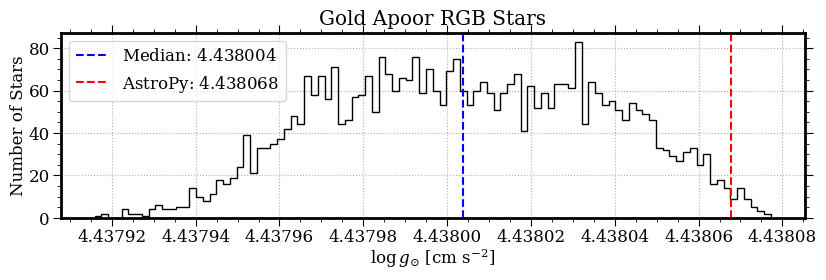

In [5]:
Logg_Sol = np.log10((const.G * (1 * u.solMass) / (1 * u.solRad) ** 2).to(u.cm / u.s ** 2).value)
data = df['Logg_Seis'] - np.log10(df['Mass'] / df['Radius'] ** 2)
# last_bin = np.histogram(data, bins=100)[0][-1]
Logg_Med = np.median(data)

fig, ax = plt.subplots(figsize=(9.6, 2.4))
ax.hist(data, bins=100, histtype='step', color='k')  # ,
# label=f'{len(df)} in total, {last_bin} in last bin')
ax.axvline(Logg_Med, color='b', ls='--', lw=1.5, label=rf'Median: ${Logg_Med:.6f}$')
ax.axvline(Logg_Sol, color='r', ls='--', lw=1.5, label=rf'AstroPy: ${Logg_Sol:.6f}$')
ax.legend(loc='upper left')
# ax.set_ylim(top=200)

ax.set_xlabel(r'$\log g_{\odot}$ [cm s$^{-2}$]')
ax.set_ylabel('Number of Stars')
ax.set_title('Gold Apoor RGB Stars')
format_axis(ax)
plt.show()

# Sample Selection

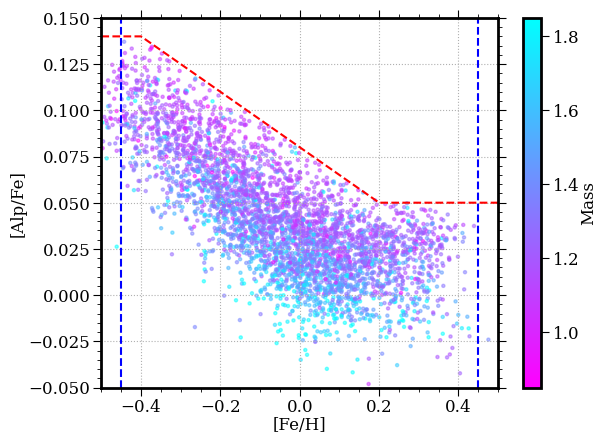

In [6]:
fig, ax = plt.subplots(figsize=(6.4, 4.8))
cmap = mpl.colormaps['cool_r']
norm = mpl.colors.Normalize(vmin=0.85, vmax=1.85)

ax.scatter(df['[Fe/H]'], df['[Alp/Fe]'], s=5, c=cmap(norm(df['Mass'])), alpha=0.5)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='Mass')

ax.plot([-0.5, -0.4, 0.2, 0.5], [0.14, 0.14, 0.05, 0.05], 'r--', lw=1.5)
for FeH in [-0.45, 0.45]: ax.axvline(FeH, color='b', ls='--', lw=1.5)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.05, 0.15)

ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[Alp/Fe]')
# ax.set_title('Gold RGB Apoor Stars')
format_axis(ax)
plt.show()

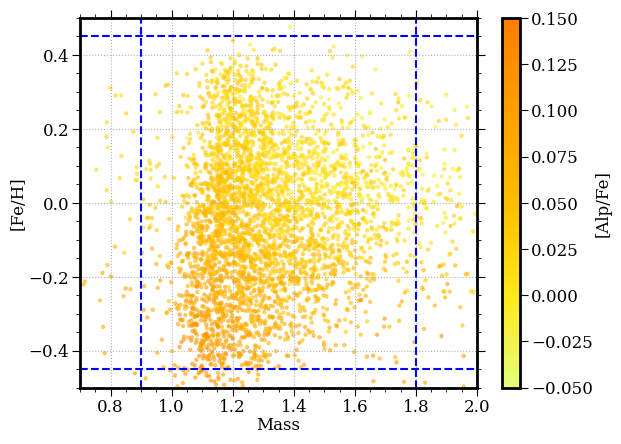

In [7]:
fig, ax = plt.subplots(figsize=(6.4, 4.8))
cmap = mpl.colormaps['Wistia']
norm = mpl.colors.Normalize(vmin=-0.05, vmax=0.15)

ax.scatter(df['Mass'], df['[Fe/H]'], s=5, c=cmap(norm(df['[Alp/Fe]'])), alpha=0.5)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='[Alp/Fe]')

for Mass in [0.90, 1.80]: ax.axvline(Mass, color='b', ls='--', lw=1.5)
for FeH in [-0.45, 0.45]: ax.axhline(FeH, color='b', ls='--', lw=1.5)
ax.set_xlim(0.7, 2.0)
ax.set_ylim(-0.5, 0.5)

ax.set_xlabel('Mass')
ax.set_ylabel('[Fe/H]')
# ax.set_title('Gold RGB Apoor Stars')
format_axis(ax)
plt.show()

In [8]:
df = df[(df['Mass'] > 0.90) & (df['Mass'] < 1.80) & (df['[Fe/H]'] > -0.45) & (df['[Fe/H]'] < 0.45)]
len(df)

3586

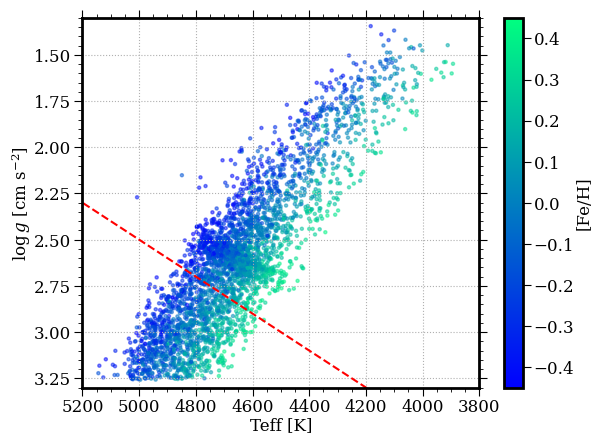

In [9]:
fig, ax = plt.subplots(figsize=(6.4, 4.8))
cmap = mpl.colormaps['winter']
norm = mpl.colors.Normalize(vmin=-0.45, vmax=0.45)

ax.scatter(df['Teff'], df['Logg_Seis'], s=5, c=cmap(norm(df['[Fe/H]'])), alpha=0.5)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='[Fe/H]')

ax.plot([4000, 5500], [3.5, 2.0], 'r--', lw=1.5)
ax.set_xlim(5200, 3800)
ax.set_ylim(3.3, 1.3)

ax.set_xlabel('Teff [K]')
ax.set_ylabel(r'$\log g$ [cm s$^{-2}$]')
# ax.set_title('Gold RGB Apoor Stars')
format_axis(ax)
plt.show()

In [10]:
np.count_nonzero(df['Teff'] + df['Logg_Seis'] * 1000 > 7500)
# df_ = df[df['Teff'] + df['Logg_Seis'] * 1000 > 7500]
# len(df_)

1259

In [11]:
df.to_csv('Table4_Apoor_RGB_Gold.csv')

if False:  # 8/28/2024
    df2 = pd.read_csv('Table4_Apoor_RGB_Gold.csv', index_col='KIC')
    for col in COLUMNS:
        if col == 'KIC': continue
        print(np.abs(df[col] - df2[col]).max())